# Using R With Quandl Data

We begin by ensuring a few key R packages are loaded

In [1]:
library(MASS)
library(Quandl)
library(ggplot2)
library(stringr)
library(R.cache)
library(data.table)

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
R.cache v0.14.0 (2019-12-06 06:10:16 UTC) successfully loaded. See ?R.cache for help.

Attaching package: ‘data.table’

The following objects are masked from ‘package:xts’:

    first, last



We are likely to run this notebook over and over, so we add memoizaiton to the data loading function.  This makes testing and re-running our code far faster, and even lets us work offline.

In [7]:
reload.data = TRUE

if (exists("QLoad")) {
    print("QLoad is already defined")
} else {
    QLoad = R.cache::addMemoization(Quandl::Quandl)
}


[1] "QLoad is already defined"


### Load the Data

Now we have the code that loads our raw data for Exxon Mobil (XOM) and the Oil futures.

In [9]:
if (reload.data) {
    Quandl.api_key(BrianBoonstraPrivateKeys.Quandl)
    cat("Data Reload/n")
    xom.raw = QLoad(c('WIKI/XOM'))
    oil.raw = QLoad(c('NSE/OIL'))
    }


Data Reload/n

#### Premium Data

We also subscribe to Quandl's premium data service, which has been professionally assembled

In [6]:
if (reload.data) {
    XSD = QLoad("EOD/HYLS")
    }

In [7]:
head(XSD)

Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
2020-04-28,44.80,44.800,44.3531,44.510,350436,0.000,1,44.80,44.800,44.3531,44.510,350436
2020-04-27,44.78,44.840,44.5000,44.585,761201,0.000,1,44.78,44.840,44.5000,44.585,761201
2020-04-24,44.85,44.870,44.5400,44.650,331349,0.000,1,44.85,44.870,44.5400,44.650,331349
2020-04-23,44.77,45.060,44.7100,44.840,263500,0.000,1,44.77,45.060,44.7100,44.840,263500
2020-04-22,44.66,44.878,44.4900,44.750,924130,0.000,1,44.66,44.878,44.4900,44.750,924130
2020-04-21,44.91,44.920,44.4300,44.460,376697,0.206,1,44.91,44.920,44.4300,44.460,376697


We can convert to returns quite easily.  Note there is no 2-day return on a Friday

In [8]:
HYLS_P_tbl = data.table::data.table(XSD[,c('Date', 'Adj_Close')], key='Date')
HYLS_P_tbl[, LDate := Date+2L]

HYLS_P_tbl[, Later := HYLS_P_tbl[.(Date=Date+2L), Adj_Close, roll=+2, mult="last", on="Date"]]
HYLS_P_tbl[, TwoDayFwdReturn := Later/Adj_Close-1]


tail(HYLS_P_tbl, 8)

Date,Adj_Close,LDate,Later,TwoDayFwdReturn
2020-04-17,45.60868,2020-04-19,45.60868,0.000000000
2020-04-20,45.02140,2020-04-22,44.75000,-0.006028218
2020-04-21,44.46000,2020-04-23,44.84000,0.008547009
2020-04-22,44.75000,2020-04-24,44.65000,-0.002234637
2020-04-23,44.84000,2020-04-25,44.65000,-0.004237288
2020-04-24,44.65000,2020-04-26,44.65000,0.000000000
2020-04-27,44.58500,2020-04-29,44.51000,-0.001682180
2020-04-28,44.51000,2020-04-30,44.51000,0.000000000


In [ ]:
HYLS_P_tbl[, FwdReturn2Periods := ]

tail(HYLS_P_tbl, 8)

#### Cleanup

Adjust column names so that we can merge the two data sets into a single data frame for analysis

In [8]:
xom <- xom.raw
oil <- oil.raw
names(xom) <- paste("WIKI.XOM -",names(xom))
names(oil) <- paste("NSE.OIL -",names(oil))
names(xom)[1] <-"Date"
names(oil)[1] <-"Date"
raw_data = merge(xom, oil)
names(raw_data)

[1] "Date"                           "WIKI.XOM - Open"               
 [3] "WIKI.XOM - High"                "WIKI.XOM - Low"                
 [5] "WIKI.XOM - Close"               "WIKI.XOM - Volume"             
 [7] "WIKI.XOM - Ex-Dividend"         "WIKI.XOM - Split Ratio"        
 [9] "WIKI.XOM - Adj. Open"           "WIKI.XOM - Adj. High"          
[11] "WIKI.XOM - Adj. Low"            "WIKI.XOM - Adj. Close"         
[13] "WIKI.XOM - Adj. Volume"         "NSE.OIL - Open"                
[15] "NSE.OIL - High"                 "NSE.OIL - Low"                 
[17] "NSE.OIL - Last"                 "NSE.OIL - Close"               
[19] "NSE.OIL - Total Trade Quantity" "NSE.OIL - Turnover (Lacs)"

Peek at the data

In [9]:
t(head(raw_data))

,1,2,3,4,5,6
Date,2009-09-30,2009-10-01,2009-10-05,2009-10-06,2009-10-07,2009-10-08
WIKI.XOM - Open,68.98,68.39,66.79,68.01,68.48,68.97
WIKI.XOM - High,69.24,68.50,67.78,69.10,68.93,69.30
WIKI.XOM - Low,68.04,67.09,66.11,67.78,67.96,68.70
WIKI.XOM - Close,68.61,67.27,67.58,68.66,68.67,69.05
WIKI.XOM - Volume,27117400,24927000,21853000,21167400,15302500,19228800
WIKI.XOM - Ex-Dividend,0,0,0,0,0,0
WIKI.XOM - Split Ratio,1,1,1,1,1,1
WIKI.XOM - Adj. Open,54.11271,53.64988,52.39473,53.35178,53.72048,54.10487
WIKI.XOM - Adj. High,54.31668,53.73617,53.17135,54.20685,54.07349,54.36374


### Common Quant Task: Massaging The Data

Here we create a function that cleans up column names in our data, for better-looking plot labels and plot specifications

In [10]:
clean.quandl.name <- function(x) {
    cleaned <- x
    if (x=='Date') {
        
    } else {
        tryCatch({
                    parts = stringr::str_split(x, " - ",n=2)
                    first.parts = stringr::str_split(parts[[1]][[1]], 
                                                      "\\.", n=2)
                    cleaned = paste(first.parts[[1]][[2]], parts[[1]][[2]], sep=".")
                    cleaned = str_replace_all(cleaned," ","")
                    },
                 error = function(e) {cat(paste0("Err on",x,"\n"))}
                 )
    }
    stringr::str_trim(cleaned)
}

Now we can use the _clean.quandl.name_ function to make a better set of column names

In [11]:
fixed.names <- lapply(names(raw_data),clean.quandl.name)
cat(paste(fixed.names,sep="\n"))
renamed_data <- raw_data
names(renamed_data) <- fixed.names

Date XOM.Open XOM.High XOM.Low XOM.Close XOM.Volume XOM.Ex-Dividend XOM.SplitRatio XOM.Adj.Open XOM.Adj.High XOM.Adj.Low XOM.Adj.Close XOM.Adj.Volume OIL.Open OIL.High OIL.Low OIL.Last OIL.Close OIL.TotalTradeQuantity OIL.Turnover(Lacs)

In [12]:
t(head(renamed_data,5))

,1,2,3,4,5
Date,2009-09-30,2009-10-01,2009-10-05,2009-10-06,2009-10-07
XOM.Open,68.98,68.39,66.79,68.01,68.48
XOM.High,69.24,68.50,67.78,69.10,68.93
XOM.Low,68.04,67.09,66.11,67.78,67.96
XOM.Close,68.61,67.27,67.58,68.66,68.67
XOM.Volume,27117400,24927000,21853000,21167400,15302500
XOM.Ex-Dividend,0,0,0,0,0
XOM.SplitRatio,1,1,1,1,1
XOM.Adj.Open,54.11271,53.64988,52.39473,53.35178,53.72048
XOM.Adj.High,54.31668,53.73617,53.17135,54.20685,54.07349


### Examining The Data

Make a standard linear fit

In [13]:
modl <- lm(XOM.Open~OIL.Open, data=renamed_data)
summary(modl)


Call:
lm(formula = XOM.Open ~ OIL.Open, data = renamed_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.7575  -6.1336   0.0105   5.7951  19.6948 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 92.9429664  0.3542912   262.3   <2e-16 ***
OIL.Open    -0.0140487  0.0004446   -31.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.932 on 2033 degrees of freedom
Multiple R-squared:  0.3294,	Adjusted R-squared:  0.3291 
F-statistic: 998.6 on 1 and 2033 DF,  p-value: < 2.2e-16


#### Our linear fit has a *great* t-statistic.  It must be a superb description of the data!

But isn't it suspicious that the slope is negative rather than positive?  Let's take a closer look

In [14]:
gp <- ggplot(renamed_data, aes(x=OIL.Open, y=XOM.Open))+geom_point()+geom_smooth(method=lm)

`geom_smooth()` using formula 'y ~ x'


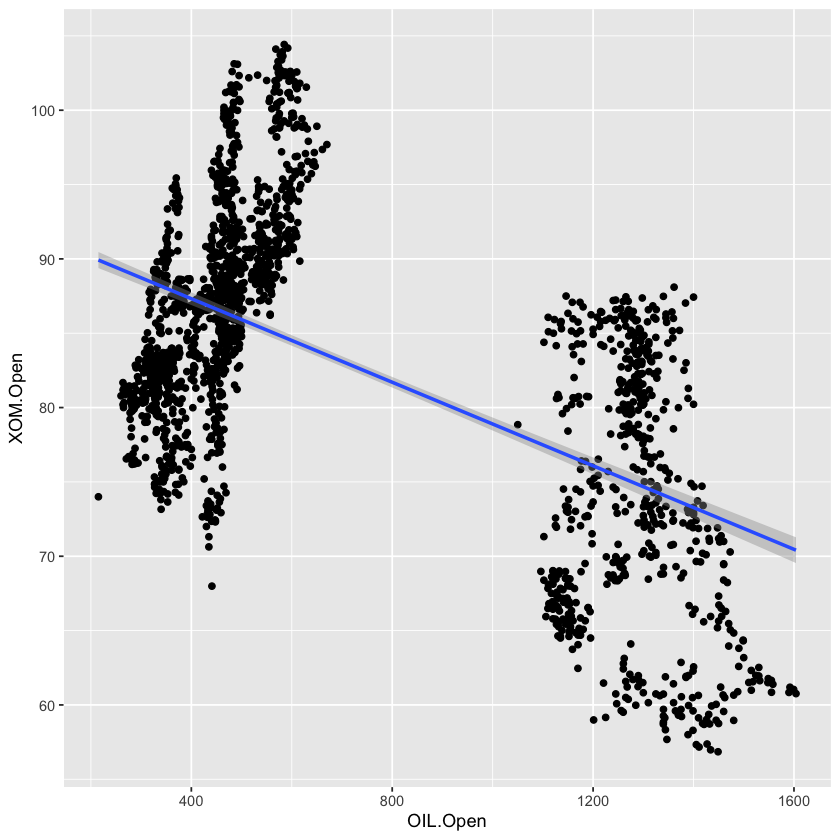

In [15]:
print(gp)